In [11]:
import pandas as pd

# Load the datasets
ratings_df = pd.read_csv('ratings.csv')
movies_df = pd.read_csv('movies.csv')

# Display the first few rows
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [12]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Check for missing values

In [13]:
   print(ratings_df.isnull().sum())
   print(movies_df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64


### Merge movie dataset with ratings

In [14]:
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

In [21]:
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,9,16,4.0,842686699,Casino (1995),Crime|Drama
2,12,16,1.5,1144396284,Casino (1995),Crime|Drama
3,24,16,4.0,963468757,Casino (1995),Crime|Drama
4,29,16,3.0,836820223,Casino (1995),Crime|Drama


In [16]:
    # Calculate average rating for each movie
    avg_ratings = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False)
   
    # Count occurrences of each genre
    genre_counts = merged_df['genres'].str.split('|').explode().value_counts()
   
   # Number of ratings per user
    user_ratings_count = merged_df['userId'].value_counts()
    
    # Print average rating per movie (top 5 for brevity)
    print("Top 5 Movies by Average Rating:")
    print(avg_ratings.head(5))

    # Print the distribution of genres
    print("\nGenre Distribution (Top 10):")
    print(genre_counts.head(10))

    # Print the number of ratings per user (top 5 for brevity)
    print("\nTop 5 Users by Number of Ratings:")
    print(user_ratings_count.head(5))

Top 5 Movies by Average Rating:
title
Saddest Music in the World, The (2003)    5.0
Interstate 60 (2002)                      5.0
Gunfighter, The (1950)                    5.0
Heima (2007)                              5.0
Limelight (1952)                          5.0
Name: rating, dtype: float64

Genre Distribution (Top 10):
Drama        46960
Comedy       38055
Action       31205
Thriller     29288
Adventure    23076
Romance      19094
Crime        18291
Sci-Fi       16795
Fantasy      10889
Mystery       8320
Name: genres, dtype: int64

Top 5 Users by Number of Ratings:
668    5678
575    2837
458    2086
232    1421
310    1287
Name: userId, dtype: int64


#### Visualization of movie rating data

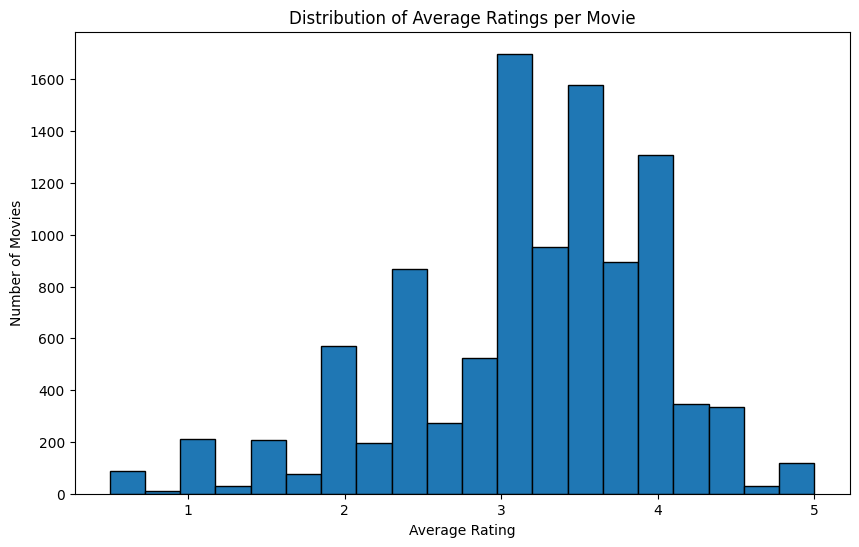

In [17]:
import matplotlib.pyplot as plt

# Calculate average rating per movie
avg_ratings = merged_df.groupby('title')['rating'].mean()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_ratings, bins=20, edgecolor='black')
plt.title("Distribution of Average Ratings per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.show()

### Visualization of ten most common genres

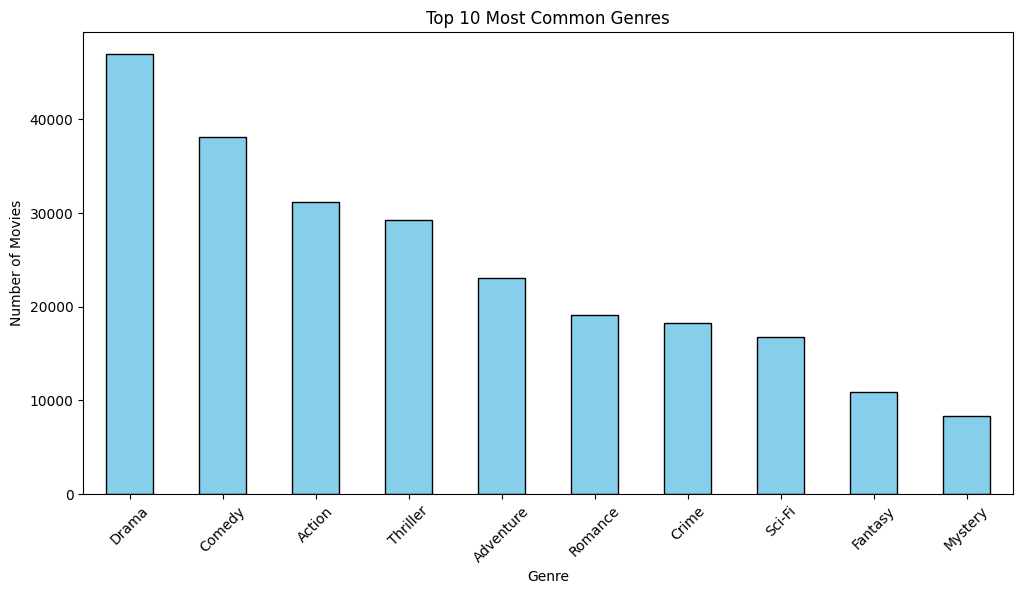

In [18]:
# Count occurrences of each genre
genre_counts = merged_df['genres'].str.split('|').explode().value_counts()

# Plot top 10 genres
plt.figure(figsize=(12, 6))
genre_counts.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Top 10 Most Common Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45)
plt.show()

### Rating Count by User

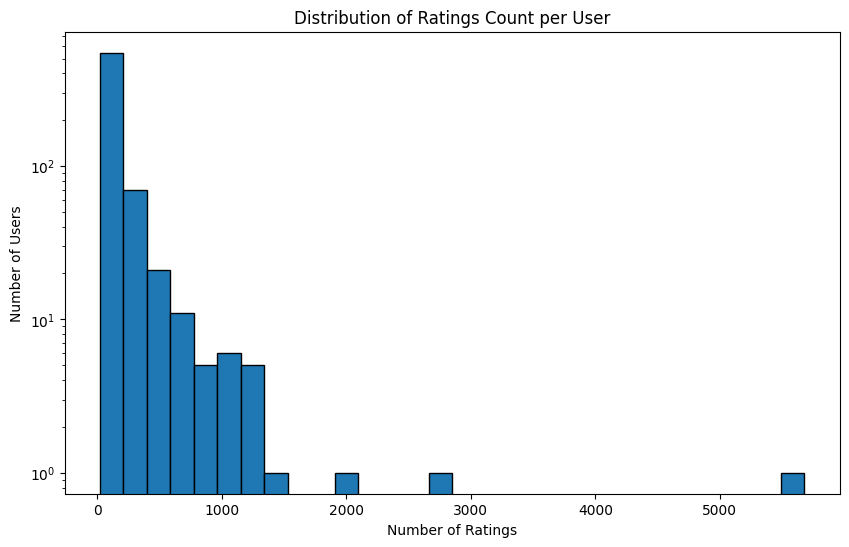

In [19]:
user_ratings_count = merged_df['userId'].value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=30, edgecolor='black')
plt.title("Distribution of Ratings Count per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.yscale('log')  # Use a log scale if distribution is skewed
plt.show()

### Average Rating by year of movie release

In [26]:
# Use regex to extract the year from the title
merged_df['release_year'] = merged_df['title'].str.extract(r'\((\d{4})\)')

# Convert the extracted year to integer, handling NaN values by filling with a default value (e.g., 0 or leave as NaN)
merged_df['release_year'] = merged_df['release_year'].fillna(1970).astype(int)


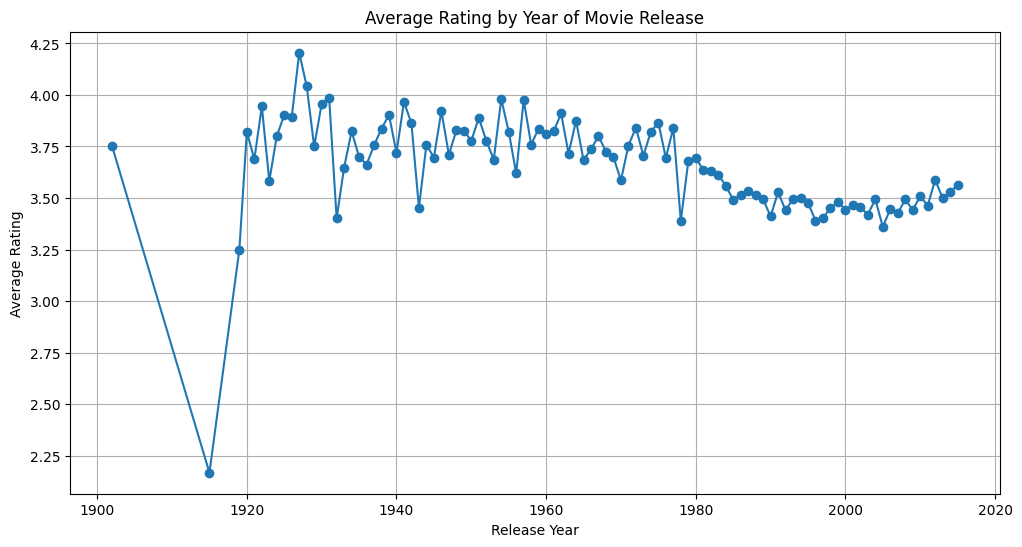

In [27]:
# Calculate average rating by release year
avg_rating_by_year = merged_df.groupby('release_year')['rating'].mean()

# Plot line chart
plt.figure(figsize=(12, 6))
avg_rating_by_year.plot(kind='line', marker='o')
plt.title("Average Rating by Year of Movie Release")
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.grid()
plt.show()

### Heat Map

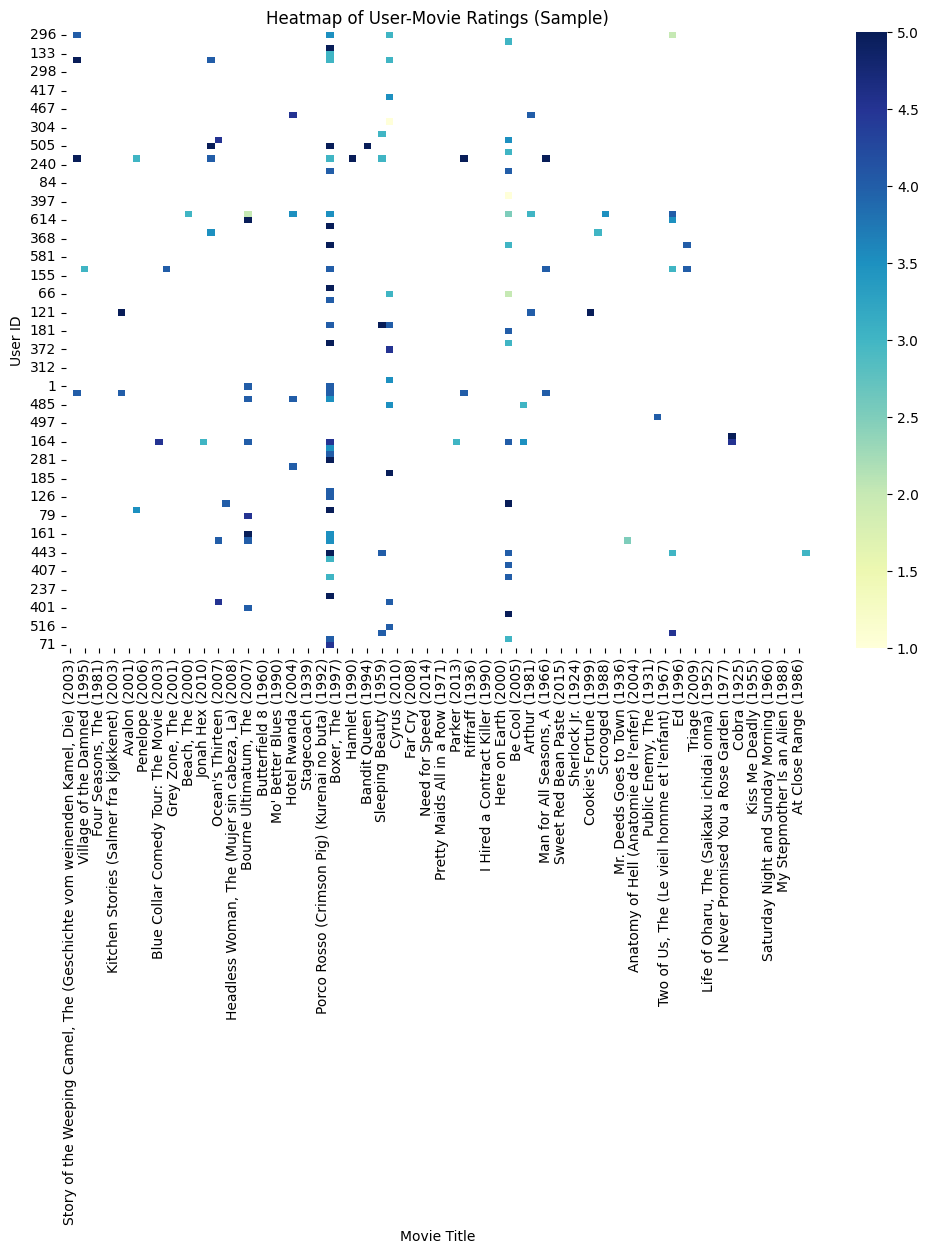

In [32]:
import seaborn as sns

# Sample the user-item matrix for visualization
user_item_sample = merged_df.pivot_table(index='userId', columns='title', values='rating').sample(100, axis=1).sample(100, axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(user_item_sample, cmap='YlGnBu', cbar=True)
plt.title("Heatmap of User-Movie Ratings (Sample)")
plt.xlabel("Movie Title")
plt.ylabel("User ID")
plt.show()

### Creating a User-Item Matrix

In [33]:
   user_item_matrix = merged_df.pivot_table(index='userId', columns='title', values='rating').fillna(3)

 ### Collaborative Filtering Using Matrix Factorization

In [36]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data for Surprise library
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD model
svd = SVD()
svd.fit(trainset)

# Predict and evaluate
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 0.8650


## Building a Content-Based Filtering Model


 #### Handling Genres

In [37]:
# Split genres into individual columns
genre_dummies = movies_df['genres'].str.get_dummies('|')
movies_with_genres = pd.concat([movies_df, genre_dummies], axis=1)

#### Calculate Similarities

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
genre_similarity = cosine_similarity(movies_with_genres[genre_dummies.columns])

#### Making Recommendations

In [39]:
def get_similar_movies(movie_title, similarity_matrix, movies_df, top_n=10):
    # Get the index of the movie
    idx = movies_df[movies_df['title'] == movie_title].index[0]
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity scores
    sorted_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similar_movie_indices = [i[0] for i in sorted_scores[1:top_n+1]]
    
    return movies_df.iloc[similar_movie_indices]

# Example recommendation
print(get_similar_movies("Toy Story (1995)", genre_similarity, movies_df))

      movieId                                              title  \
1815     2294                                        Antz (1998)   
2496     3114                                 Toy Story 2 (1999)   
2967     3754     Adventures of Rocky and Bullwinkle, The (2000)   
3166     4016                   Emperor's New Groove, The (2000)   
3811     4886                              Monsters, Inc. (2001)   
6617    33463  DuckTales: The Movie - Treasure of the Lost La...   
6997    45074                                   Wild, The (2006)   
7382    53121                             Shrek the Third (2007)   
7987    65577                     Tale of Despereaux, The (2008)   
9215    91355  Asterix and the Vikings (Astérix et les Viking...   

                                           genres  
1815  Adventure|Animation|Children|Comedy|Fantasy  
2496  Adventure|Animation|Children|Comedy|Fantasy  
2967  Adventure|Animation|Children|Comedy|Fantasy  
3166  Adventure|Animation|Children|Comedy|F